# Imbalanced data experiments

*Author: Mariusz Wiśniewski*

## Setup

### Imports

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import (
    NearMiss,
    CondensedNearestNeighbour,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    TomekLinks,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    recall_score,
    precision_score,
)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import resample

### Setting up default plotting parameters

In [2]:
plt.rcParams["figure.figsize"] = [20.0, 7.0]
plt.rcParams.update({"font.size": 22})

sns.set_palette("viridis")
sns.set_style("white")
sns.set_context("talk", font_scale=0.8)

### Function printing evaluation of a method

In [3]:
def print_evaluation(name, value_set, x_train, ground_truth, predicted_label):
    print("\n")
    print(name.upper())

    print("Counts")
    print(value_set.value_counts())

    # summarize the new class distribution
    counter = Counter(value_set)

    # scatter plot of examples by class label
    for label, _ in counter.items():
        color = "#e67e22" if label == 0 else "#1abc9c"
        row_ix = np.where(value_set == label)[0]
        plt.scatter(
            x_train.iloc[row_ix, 0],
            x_train.iloc[row_ix, 1],
            label=str(label),
            color=color,
        )
    plt.title(name)
    plt.savefig(f'output/{name.replace(" ", "_")}.png')
    plt.show()
    plt.clf()

    print("\nConfusion matrix")
    print(pd.DataFrame(confusion_matrix(ground_truth, predicted_label)))

    print("\nAccuracy: ", round(accuracy_score(ground_truth, predicted_label), 2))
    print("Recall: ", round(recall_score(ground_truth, predicted_label), 2))
    print("Precision: ", round(precision_score(ground_truth, predicted_label), 2))
    print("f1 score: ", round(f1_score(ground_truth, predicted_label), 2))

### Read data and split it to training and testing sets

In [4]:
df = pd.read_csv("creditcard.csv")

print(df.shape)
print(df.Class.value_counts())

(284807, 31)
0    284315
1       492
Name: Class, dtype: int64


In [5]:
# print percentage of questions where target == 1
print("\n")
print(
    f"Ratio of the size of the minority class to the majority class: "
    f"{round((len(df.loc[df.Class == 1])) / (len(df.loc[df.Class == 0])) * 100, 2)}%"
)



Ratio of the size of the minority class to the majority class: 0.17%


In [6]:
# Prepare data for modeling
# Separate input features and target
y = df.Class
X = df.drop("Class", axis=1)

In [7]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=27
)

### Dummy Classifier

In [8]:
dummy = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print("Unique predicted labels: ", (np.unique(dummy_pred)))

# checking accuracy
print("Accuracy: ", round(accuracy_score(y_test, dummy_pred), 2))

Unique predicted labels:  [0]
Accuracy:  1.0


### Logistic Regression



LOGISTIC REGRESSION
Counts
0    71108
1       94
Name: 0, dtype: int64


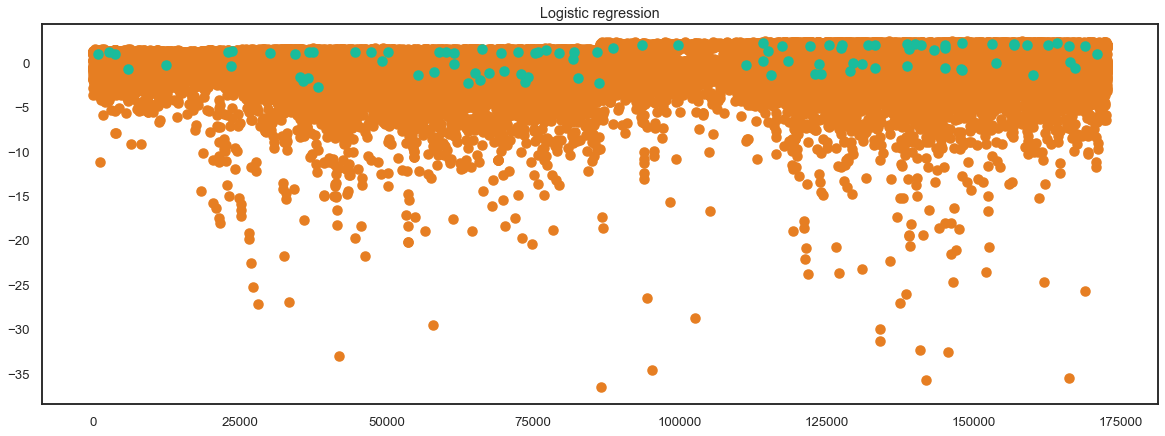


Confusion matrix
       0   1
0  71061   9
1     47  85

Accuracy:  1.0
Recall:  0.64
Precision:  0.9
f1 score:  0.75


<Figure size 1440x504 with 0 Axes>

In [9]:
# Modeling the data as is
# Train model
lr = LogisticRegression(solver="liblinear").fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Checking unique values
predictions = pd.DataFrame(lr_pred)

print_evaluation("Logistic regression", predictions[0], X_train, y_test, lr_pred)

## Preprocessing Methods

### Oversampling Techniques

#### Random Oversample

In [10]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
# print(X.head())

# separate minority and majority classes
not_fraud = X[X.Class == 0]
fraud = X[X.Class == 1]

In [11]:
# upsample minority
fraud_upsampled = resample(
    fraud,
    replace=True,  # sample with replacement
    n_samples=len(not_fraud),  # match number in majority class
    random_state=27,
)  # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])
dataset = upsampled



RANDOM OVERSAMPLE
Counts
0    213245
1    213245
Name: Class, dtype: int64


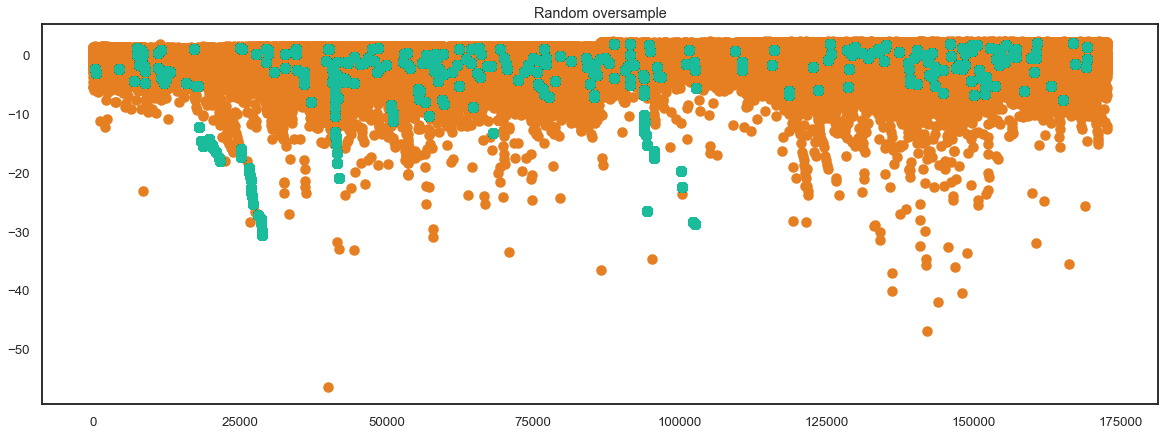


Confusion matrix
       0     1
0  69717  1353
1     17   115

Accuracy:  0.98
Recall:  0.87
Precision:  0.08
f1 score:  0.14


<Figure size 1440x504 with 0 Axes>

In [12]:
# trying logistic regression again with the balanced dataset
y_train_up = upsampled.Class
X_train_up = upsampled.drop("Class", axis=1)

upsampled = LogisticRegression(solver="liblinear").fit(X_train_up, y_train_up)
upsampled_pred = upsampled.predict(X_test)

print_evaluation(
    "Random oversample",
    y_train_up,
    X_train_up,
    y_test,
    upsampled_pred,
)

#### SMOTE



SMOTE
Counts
0    213245
1    213245
Name: Class, dtype: int64


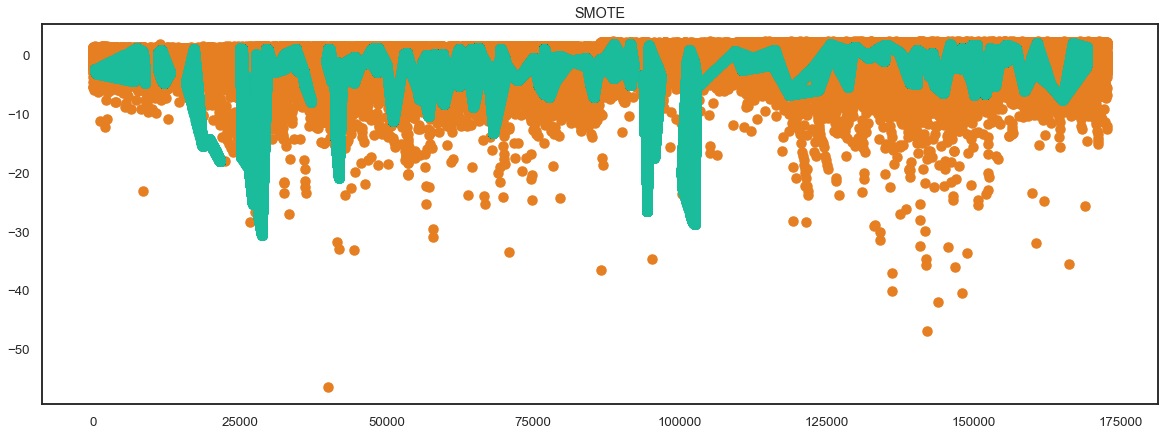


Confusion matrix
       0    1
0  70081  989
1     18  114

Accuracy:  0.99
Recall:  0.86
Precision:  0.1
f1 score:  0.18


<Figure size 1440x504 with 0 Axes>

In [13]:
sm = SMOTE(random_state=27)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

smote = LogisticRegression(solver="liblinear").fit(X_train_smote, y_train_smote)
smote_pred = smote.predict(X_test)

print_evaluation("SMOTE", y_train_smote, X_train_smote, y_test, smote_pred)

#### Borderline-1 SMOTE



BORDERLINE1-SMOTE
Counts
0    213245
1    213245
Name: Class, dtype: int64


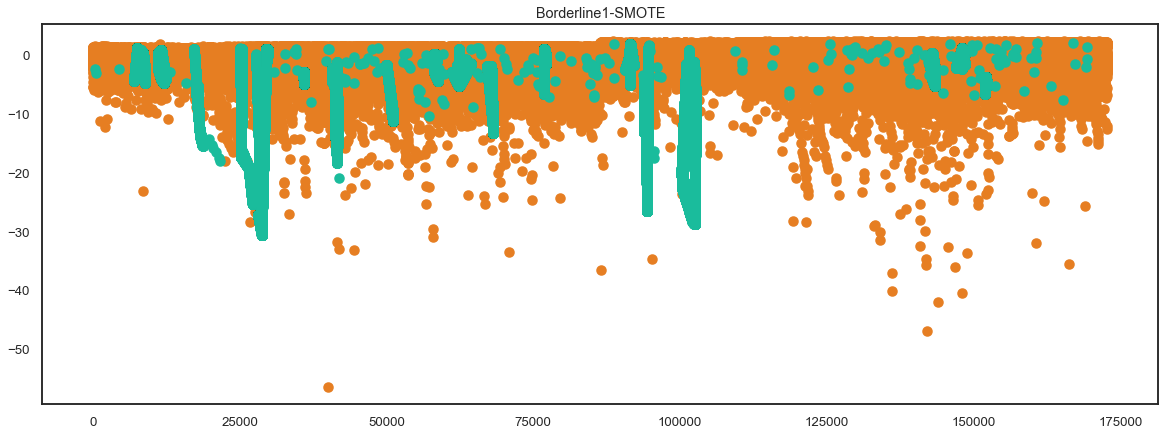


Confusion matrix
       0    1
0  70835  235
1     47   85

Accuracy:  1.0
Recall:  0.64
Precision:  0.27
f1 score:  0.38


<Figure size 1440x504 with 0 Axes>

In [14]:
b1sm = BorderlineSMOTE(kind="borderline-1", random_state=27)
X_train_b1smote, y_train_b1smote = b1sm.fit_resample(X_train, y_train)

b1smote = LogisticRegression(solver="liblinear").fit(X_train_b1smote, y_train_b1smote)
b1smote_pred = b1smote.predict(X_test)

print_evaluation("Borderline1-SMOTE", y_train_b1smote, X_train_b1smote, y_test, b1smote_pred)

#### Borderline-2 SMOTE



BORDERLINE2-SMOTE
Counts
0    213245
1    213244
Name: Class, dtype: int64


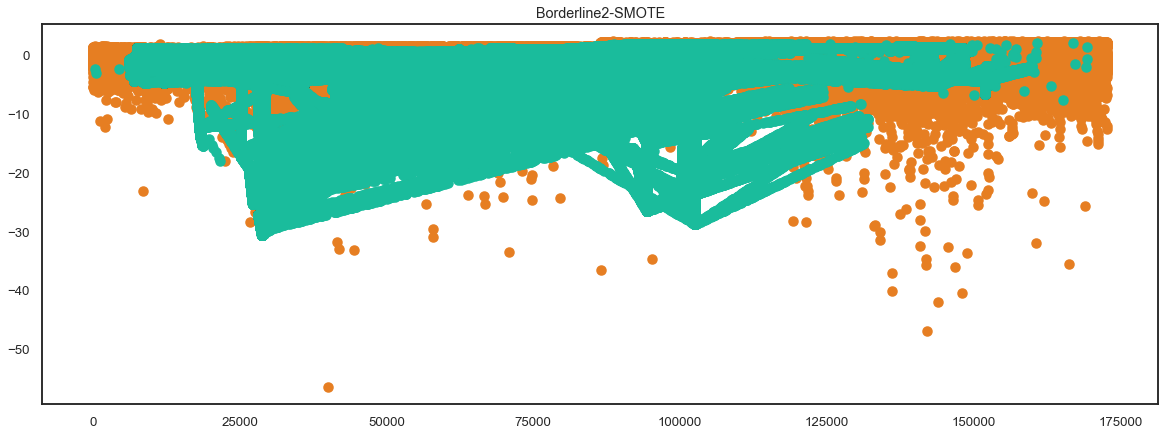


Confusion matrix
       0    1
0  70596  474
1     29  103

Accuracy:  0.99
Recall:  0.78
Precision:  0.18
f1 score:  0.29


<Figure size 1440x504 with 0 Axes>

In [15]:
b2sm = BorderlineSMOTE(kind="borderline-2", random_state=27)
X_train_b2smote, y_train_b2smote = b2sm.fit_resample(X_train, y_train)

b2smote = LogisticRegression(solver="liblinear").fit(X_train_b2smote, y_train_b2smote)
b2smote_pred = b2smote.predict(X_test)

print_evaluation("Borderline2-SMOTE", y_train_b2smote, X_train_b2smote, y_test, b2smote_pred)

### Undersampling Techniques

#### Random Undersampling

In [16]:
# downsample majority
not_fraud_downsampled = resample(
    not_fraud,
    replace=False,  # sample without replacement
    n_samples=len(fraud),  # match minority n
    random_state=27,
)  # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])
dataset = downsampled



RANDOM UNDERSAMPLE
Counts
0    360
1    360
Name: Class, dtype: int64


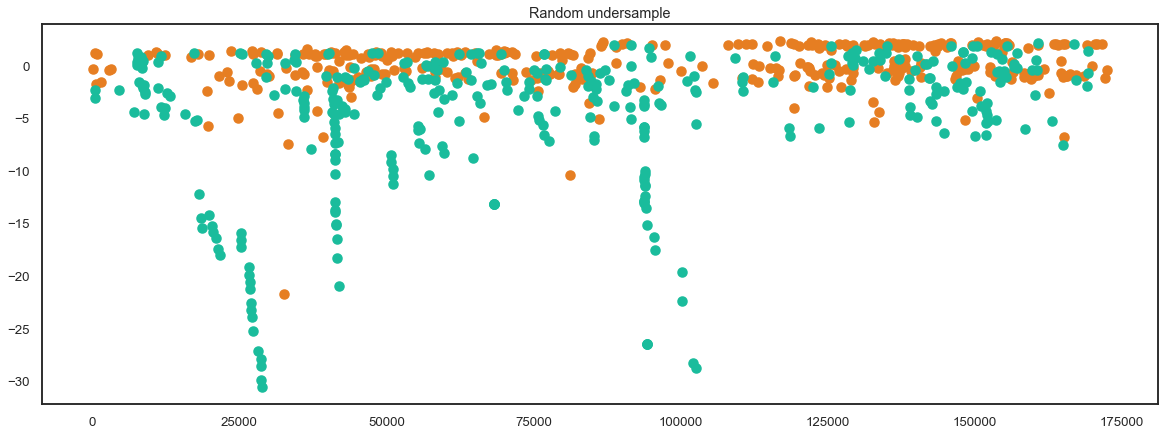


Confusion matrix
       0     1
0  69369  1701
1     18   114

Accuracy:  0.98
Recall:  0.86
Precision:  0.06
f1 score:  0.12


<Figure size 1440x504 with 0 Axes>

In [17]:
y_train_down = downsampled.Class
X_train_down = downsampled.drop("Class", axis=1)

undersampled = LogisticRegression(solver="liblinear").fit(X_train_down, y_train_down)
undersampled_pred = undersampled.predict(X_test)

print_evaluation(
    "Random undersample",
    y_train_down,
    X_train_down,
    y_test,
    undersampled_pred,
)

#### NearMiss-1



NEARMISS-1
Counts
0    360
1    360
Name: Class, dtype: int64


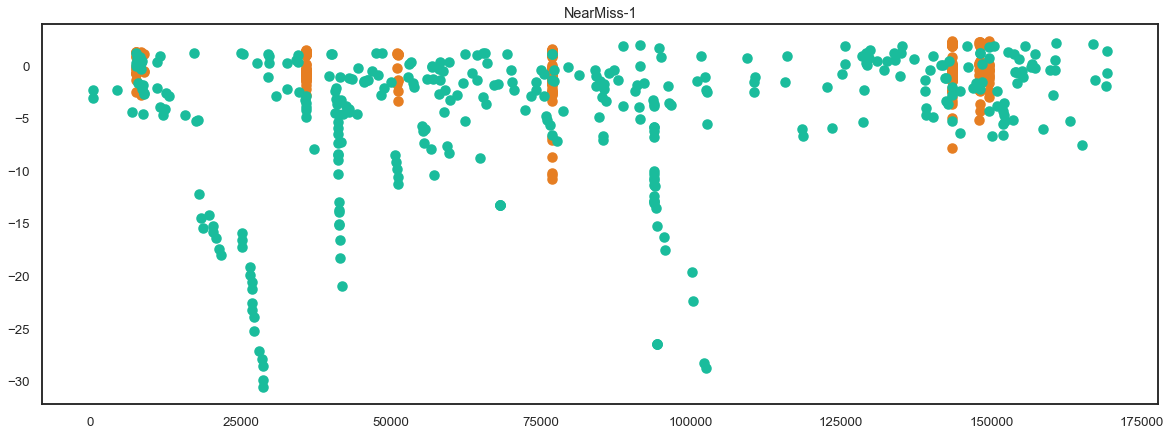


Confusion matrix
       0     1
0  61748  9322
1     13   119

Accuracy:  0.87
Recall:  0.9
Precision:  0.01
f1 score:  0.02


<Figure size 1440x504 with 0 Axes>

In [18]:
nr1 = NearMiss(version=1)
X_train_nm1, y_train_nm1 = nr1.fit_resample(X_train, y_train)

nr1 = LogisticRegression(solver="liblinear").fit(X_train_nm1, y_train_nm1)
nr1_pred = nr1.predict(X_test)

print_evaluation(
    "NearMiss-1", y_train_nm1, X_train_nm1, y_test, nr1_pred
)

#### NearMiss-2



NEARMISS-2
Counts
0    360
1    360
Name: Class, dtype: int64


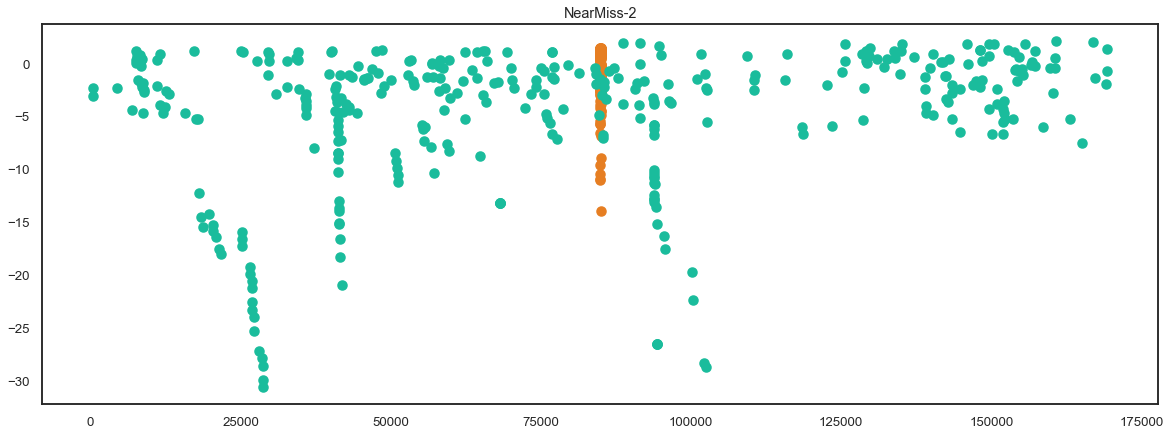


Confusion matrix
       0     1
0  65575  5495
1     12   120

Accuracy:  0.92
Recall:  0.91
Precision:  0.02
f1 score:  0.04


<Figure size 1440x504 with 0 Axes>

In [19]:
nr2 = NearMiss(version=2)
X_train_nm2, y_train_nm2 = nr2.fit_resample(X_train, y_train)

nr2 = LogisticRegression(solver="liblinear").fit(X_train_nm2, y_train_nm2)
nr2_pred = nr2.predict(X_test)

print_evaluation(
    "NearMiss-2", y_train_nm2, X_train_nm2, y_test, nr2_pred
)

#### NearMiss-3



NEARMISS-3
Counts
0    360
1    360
Name: Class, dtype: int64


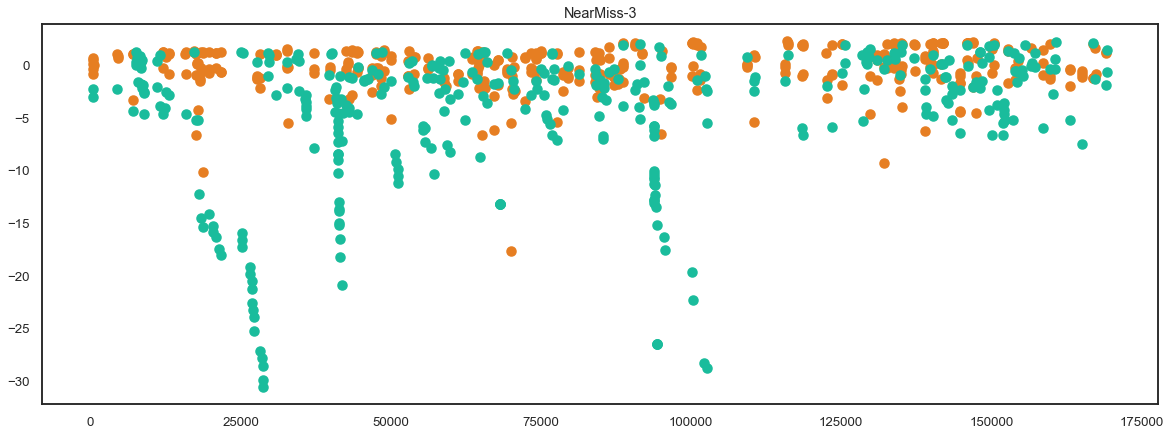


Confusion matrix
       0     1
0  69476  1594
1     17   115

Accuracy:  0.98
Recall:  0.87
Precision:  0.07
f1 score:  0.12


<Figure size 1440x504 with 0 Axes>

In [20]:
nr3 = NearMiss(version=3)
X_train_nm3, y_train_nm3 = nr3.fit_resample(X_train, y_train)

nr3 = LogisticRegression(solver="liblinear").fit(X_train_nm3, y_train_nm3)
nr3_pred = nr3.predict(X_test)

print_evaluation(
    "NearMiss-3", y_train_nm3, X_train_nm3, y_test, nr3_pred
)

#### Edited Nearest Neighbors



EDITED NEAREST NEIGHBOUR
Counts
0    212926
1       360
Name: Class, dtype: int64


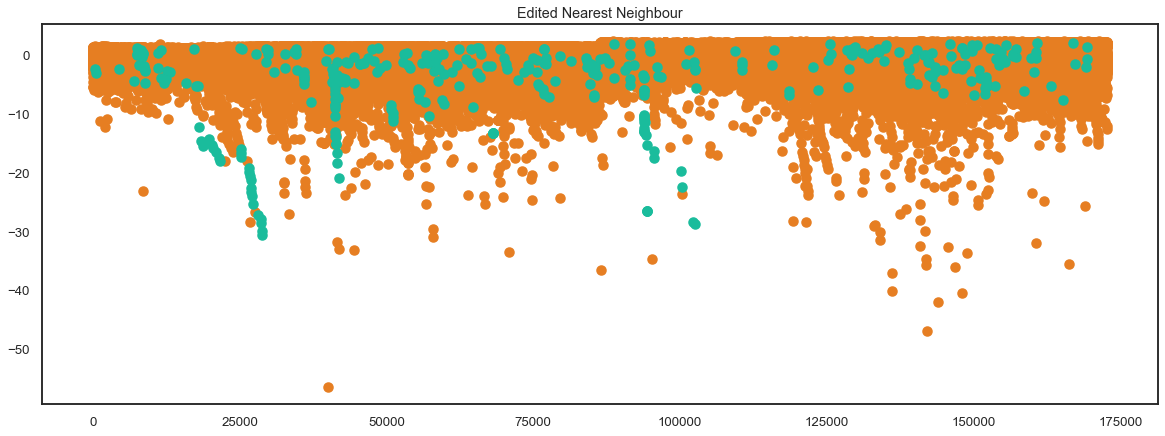


Confusion matrix
       0   1
0  71047  23
1     58  74

Accuracy:  1.0
Recall:  0.56
Precision:  0.76
f1 score:  0.65


<Figure size 1440x504 with 0 Axes>

In [21]:
enn = EditedNearestNeighbours(n_neighbors=3)
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)

enn = LogisticRegression(solver="liblinear").fit(X_train_enn, y_train_enn)
enn_pred = enn.predict(X_test)

print_evaluation(
    "Edited Nearest Neighbour",
    y_train_enn,
    X_train_enn,
    y_test,
    enn_pred,
)

#### Repeated Edited Nearest Neighbors

In [ ]:
renn = RepeatedEditedNearestNeighbours(n_neighbors=3)
X_train_renn, y_train_renn = renn.fit_resample(X_train, y_train)

renn = LogisticRegression(solver="liblinear").fit(X_train_renn, y_train_renn)
renn_pred = renn.predict(X_test)

print_evaluation(
    "Repeated Edited Nearest Neighbour",
    y_train_renn,
    X_train_renn,
    y_test,
    renn_pred,
)

#### Tomek Links Removal

In [ ]:
tl = TomekLinks()
X_train_tl, y_train_tl = tl.fit_resample(X_train, y_train)

tl = LogisticRegression(solver="liblinear").fit(X_train_tl, y_train_tl)
tl_pred = tl.predict(X_test)

print_evaluation(
    "Tomek Links Removal", y_train_tl, X_train_tl, y_test, tl_pred
)

#### Condensed Nearest Neighbor

In [ ]:
cnn = CondensedNearestNeighbour(n_neighbors=3)
X_train_cnn, y_train_cnn = cnn.fit_resample(X_train, y_train)

cnn = LogisticRegression(solver="liblinear").fit(X_train_cnn, y_train_cnn)
cnn_pred = cnn.predict(X_test)

print_evaluation(
    "Condensed Nearest Neighbour",
    y_train_cnn,
    X_train_cnn,
    y_test,
    cnn_pred,
)

## Example Imbalanced Data Classification Algorithms

### Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print_evaluation("Rain Forest Classifier", predictions[0], X_train, y_test, rfc_pred)

#### Easy Ensemble

In [ ]:
ens = EasyEnsembleClassifier()
ens = ens.fit(X_train, y_train)
ens_pred = ens.predict(X_test)

print_evaluation(
    "Easy Ensemble", y_train, X_train, y_test, ens_pred,
)

### Support Vector Machine (SVM)

In [ ]:
svm = SVC(kernel="linear", random_state=27)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print_evaluation("SVM", y_train, X_train, y_test, svm_pred)

### Borderline SVM-SMOTE

In [ ]:
svmsm = SVMSMOTE(random_state=27)
X_train_svmsmote, y_train_svmsmote = svmsm.fit_resample(X_train, y_train)

svmsmote = LogisticRegression(solver="liblinear").fit(X_train_svmsmote, y_train_svmsmote)
svmsmote_pred = svmsmote.predict(X_test)

print_evaluation("SVM-SMOTE", y_train_svmsmote, X_train_svmsmote, y_test, svmsmote_pred)